### Data (preparing and loading)

ML is a game of two parts:

1. Turn your data, whatever it is, into numbers(a representation).
1. Pick or build a model to learn the representation as best as possible

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.1+cu118'

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### Split data into training and test sets
Training Set and Validation Set

In [3]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% used training
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

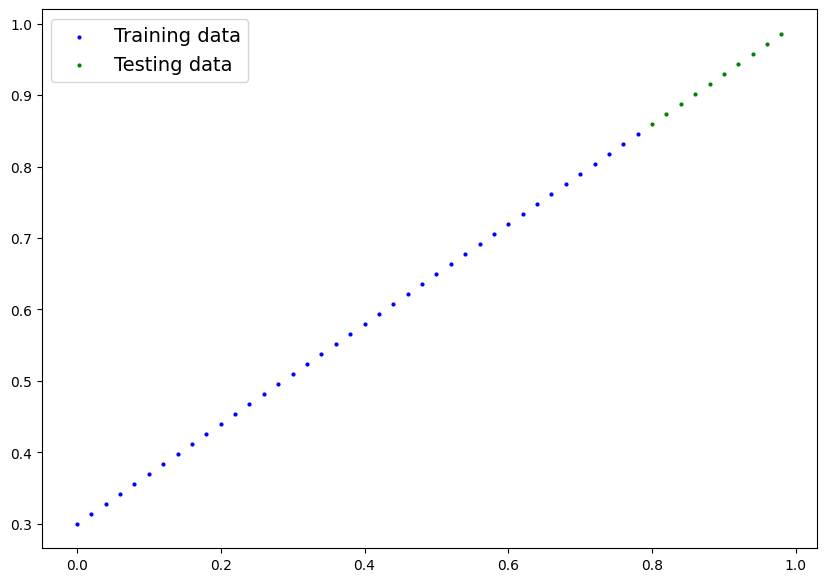

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data ub green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 14});

plot_predictions();

### Build model 


In [5]:
# Create a Linear model class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Checking the contents of a PyTorch model
create a model instance with the class we've made and check its parameters using `.parameters()`.

In [6]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model(this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

get the state (what model contains) of the model using `.state_dict()`.

In [7]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`
pass data to our model


In [8]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)


In [9]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values : \n {y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values : 
 tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


visualize them

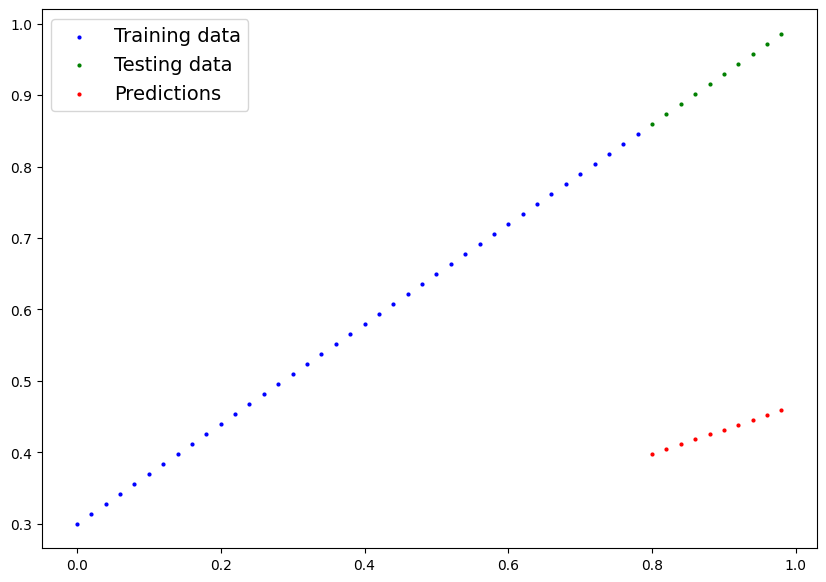

In [10]:
plot_predictions(predictions=y_preds)

In [11]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

### Training model

Create a **loss function** and **optimizer** in PyTorch

loss function: MAE, in PyTorch `torch.nn.L1loss()`

optimizer: SGD `torch.optim.SGD(params, lr)`

In [12]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is sane as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),# parameters of target model to optimize
                            lr=0.01)

In [13]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss losts to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training 
    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward loss
    y_pred = model_0(X_train)

    # 2.Calculate the loss (how different are our models predictions to thte ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing
    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test)

        # 2. Calculate the test loss
        test_loss = loss_fn(test_pred, y_test)

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss:.5f} | MAE Test Loss: {test_loss:.5f}")


Epoch: 0 | MAE Train Loss: 0.31288 | MAE Test Loss: 0.48107
Epoch: 10 | MAE Train Loss: 0.19767 | MAE Test Loss: 0.34636
Epoch: 20 | MAE Train Loss: 0.08909 | MAE Test Loss: 0.21730
Epoch: 30 | MAE Train Loss: 0.05315 | MAE Test Loss: 0.14464
Epoch: 40 | MAE Train Loss: 0.04544 | MAE Test Loss: 0.11361
Epoch: 50 | MAE Train Loss: 0.04168 | MAE Test Loss: 0.09920
Epoch: 60 | MAE Train Loss: 0.03819 | MAE Test Loss: 0.08887
Epoch: 70 | MAE Train Loss: 0.03476 | MAE Test Loss: 0.08059
Epoch: 80 | MAE Train Loss: 0.03132 | MAE Test Loss: 0.07232
Epoch: 90 | MAE Train Loss: 0.02789 | MAE Test Loss: 0.06474


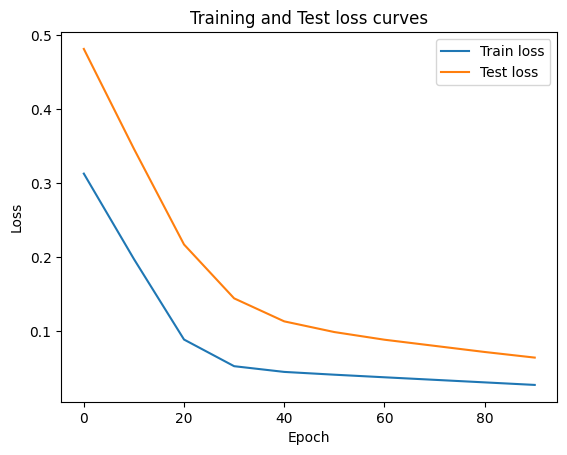

In [14]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

In [15]:
# Find our model's learned parameters
print(f"The model learned the following values for weights and bias:")
print(model_0.state_dict())
print(f"\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 4. Making predictions with a trained PyTorch model (inference)

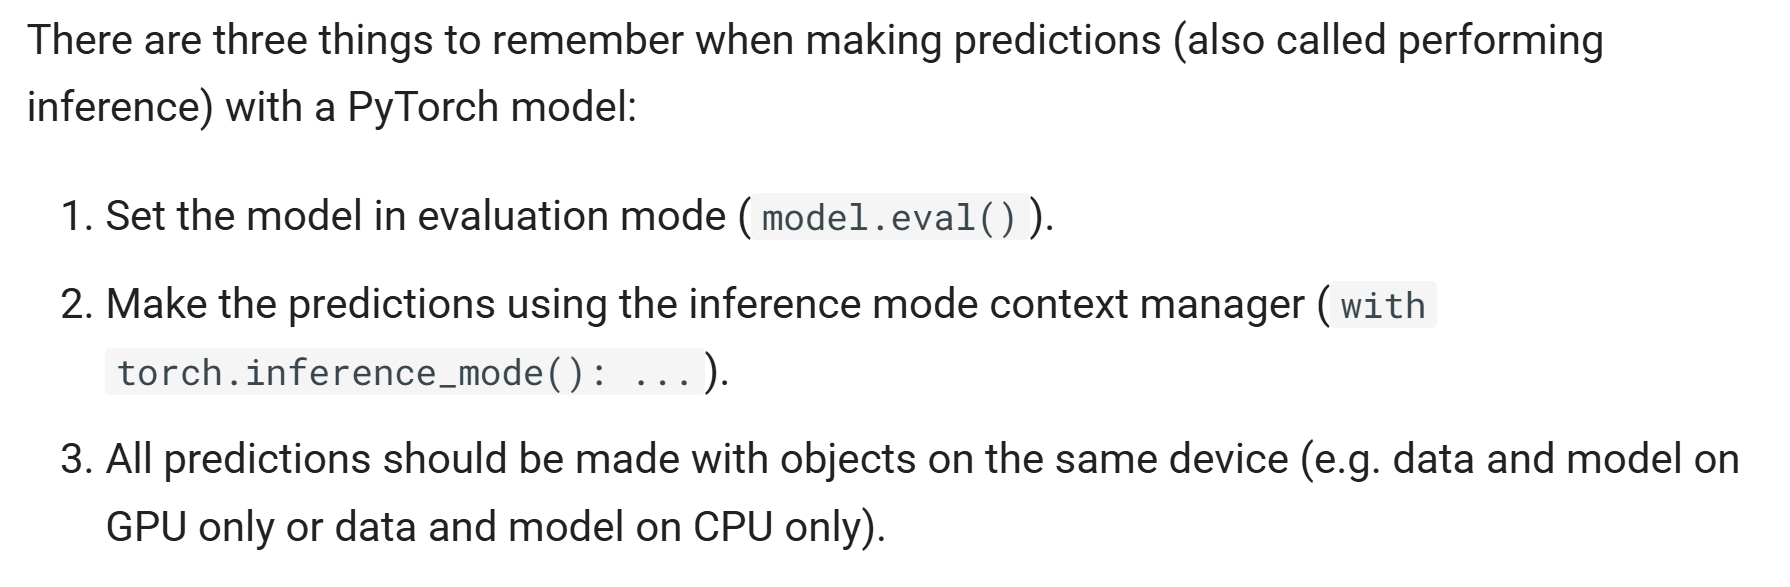

In [16]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
    # 3. Make sure the calculations are done with the model and data on the same device
    # in our case, we haven't setup device-agnostic code yet so our data and model are
    # on CPU by default
    # model_0.to(device)
    # X_test = X_test.to(device)
    y_preds = model_0(X_test)

y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

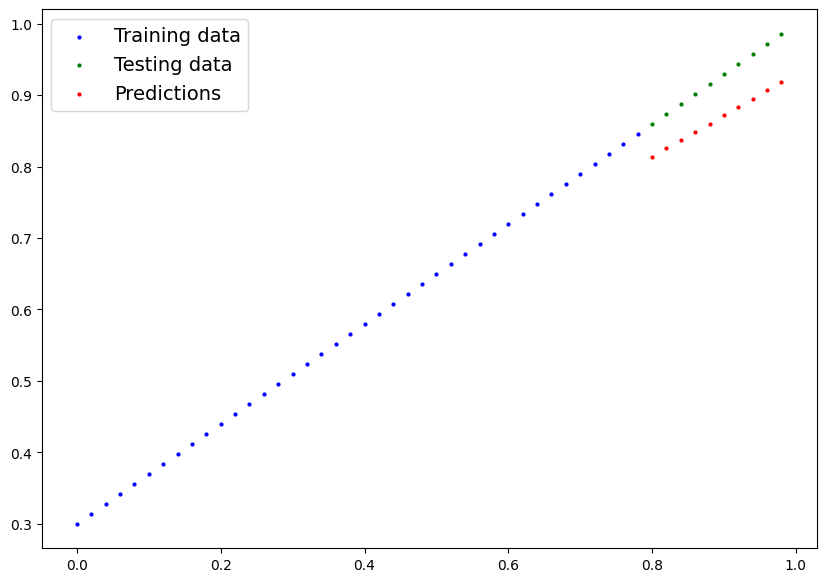

In [17]:
plot_predictions(predictions=y_preds)

### 5. Saving and loading a PyTorch model

`torch.save`: https://docs.pytorch.org/docs/stable/torch.html#torch.save

`torch.load`: 

`torch.nn.Module.load_state_dict:`

Saving a PyTorch model's `state_dict()`

Teh recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`

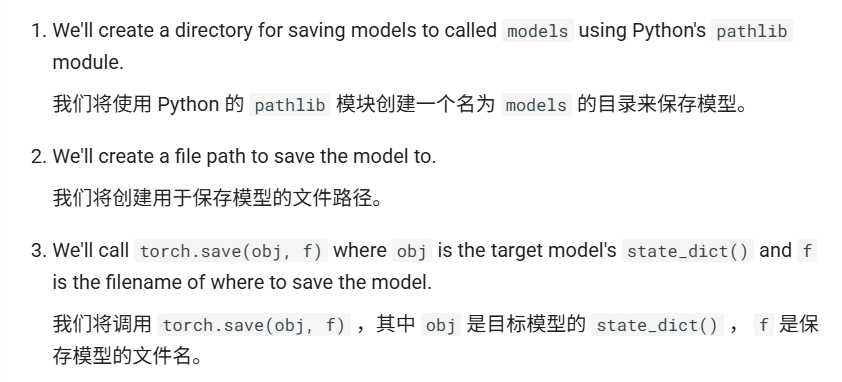

Notice: It's common convention for PyTorch saved models or objects to end with `.pt` or `.pth`, like `saved_model_01.pth`.

In [18]:
from pathlib import Path

# 1. Create models firectory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [19]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 ssliang ssliang 1680  8월 19 13:25 models/01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's `state_dict()`

we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

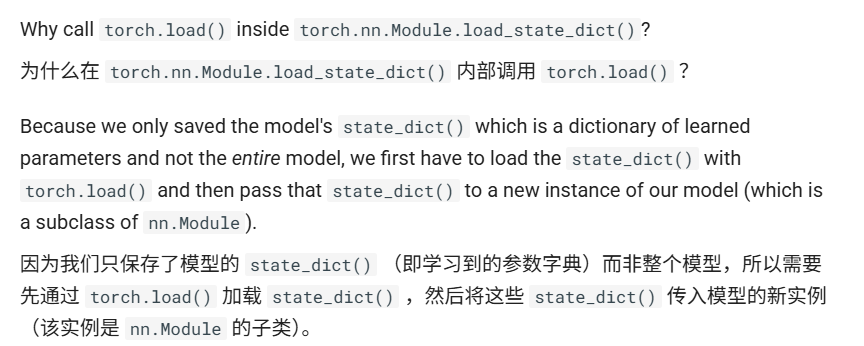

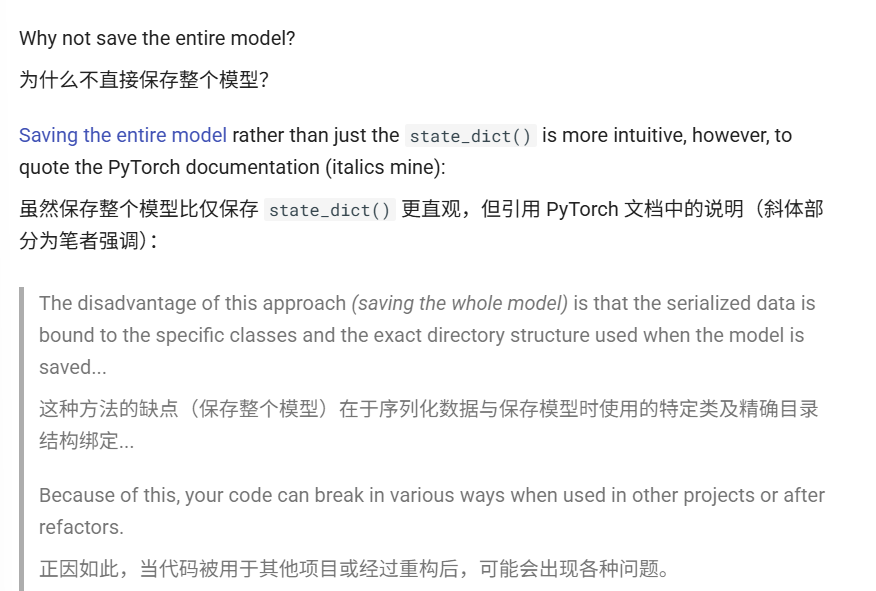

In [20]:
# Instantiate a new instance of our model
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manger ro make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [22]:
# Compare previous model predictions with loaded model predictions
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together

Except this time we'll make our code device agnostic

In [23]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cup"
print(f"Using device: {device}")

Using device: cuda


#### Data

In [24]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and lables)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [25]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

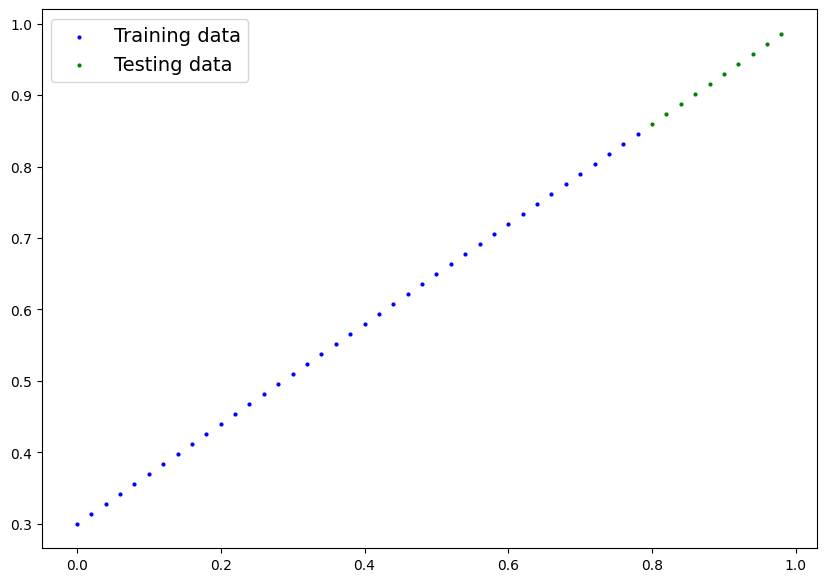

In [26]:
# Visualize them to make sure they look okay
plot_predictions(X_train, y_train, X_test, y_test)

#### Create a PyTorch Linear model

use `nn.Linear()` instead of `nn.Parameter()`

In [27]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()    


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [28]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [29]:
# to GPU
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

#### Training

In [30]:
# Create loss function
loss_fn = nn.L1Loss()

# Optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

In [31]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval()

    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. calculate loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | MAE Train Loss: {loss:.5f} | MAE Test Loss: {test_loss:.5f}")


Epoch: 0 | MAE Train Loss: 0.55518 | MAE Test Loss: 0.57398
Epoch: 100 | MAE Train Loss: 0.00622 | MAE Test Loss: 0.01409
Epoch: 200 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 300 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 400 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 500 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 600 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 700 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 800 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380
Epoch: 900 | MAE Train Loss: 0.00126 | MAE Test Loss: 0.01380


Check the parameters our models

In [32]:
# Find our model's parameters
from pprint import pprint as pp # # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pp(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
pp(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
'weights: 0.7, bias: 0.3'


In [33]:
# Making predictions
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

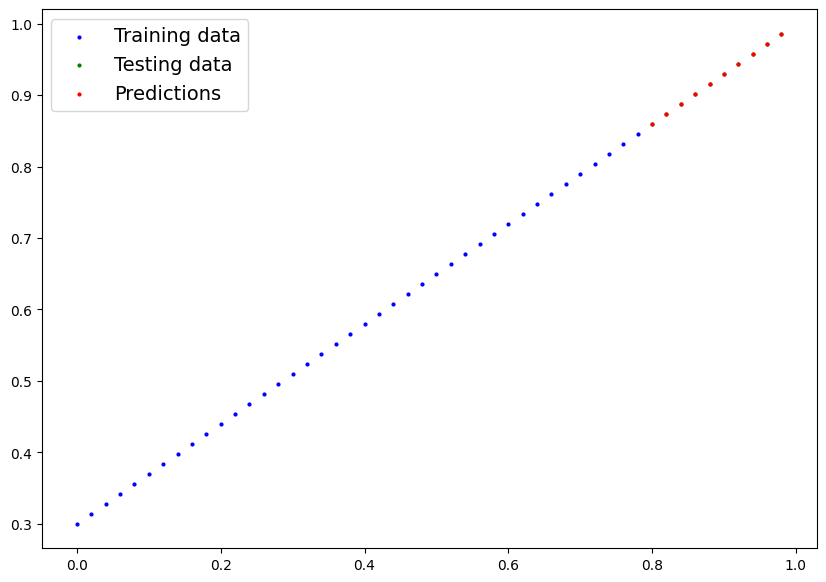

In [35]:
# Visualize it
plot_predictions(predictions=y_preds.cpu())

#### Saving and loading a model

In [36]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


Reload

In [37]:
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model: \n {loaded_model_1}")
print(f"Model on device: \n{next(loaded_model_1.parameters()).device}")

Loaded model: 
 LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: 
cuda:0


Now we can evaluate the loaded model to see if its predictions line up with the predictions made prior to saving

In [38]:
# Evalyate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')